
Iteration 1/100
Train Loss: 0.5124 | Train Accuracy: 0.7433

Iteration 2/100
Train Loss: 0.3518 | Train Accuracy: 0.8752

Iteration 3/100
Train Loss: 0.3195 | Train Accuracy: 0.8574

Iteration 4/100
Train Loss: 0.2994 | Train Accuracy: 0.9002

Iteration 5/100
Train Loss: 0.3482 | Train Accuracy: 0.8414

Iteration 6/100
Train Loss: 0.3001 | Train Accuracy: 0.9127

Iteration 7/100
Train Loss: 0.3070 | Train Accuracy: 0.8717

Iteration 8/100
Train Loss: 0.2981 | Train Accuracy: 0.9305

Iteration 9/100
Train Loss: 0.2682 | Train Accuracy: 0.8895

Iteration 10/100
Train Loss: 0.2631 | Train Accuracy: 0.8841

Iteration 11/100
Train Loss: 0.2726 | Train Accuracy: 0.9216

Iteration 12/100
Train Loss: 0.2839 | Train Accuracy: 0.8841

Iteration 13/100
Train Loss: 0.2877 | Train Accuracy: 0.8538

Iteration 14/100
Train Loss: 0.2796 | Train Accuracy: 0.9055

Iteration 15/100
Train Loss: 0.2752 | Train Accuracy: 0.9037

Iteration 16/100
Train Loss: 0.2844 | Train Accuracy: 0.8948

Iteration 17/100

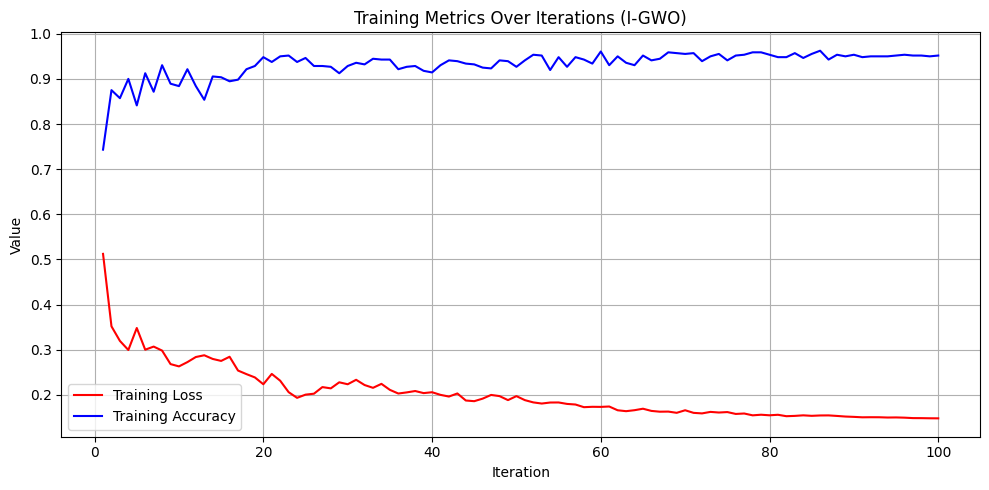

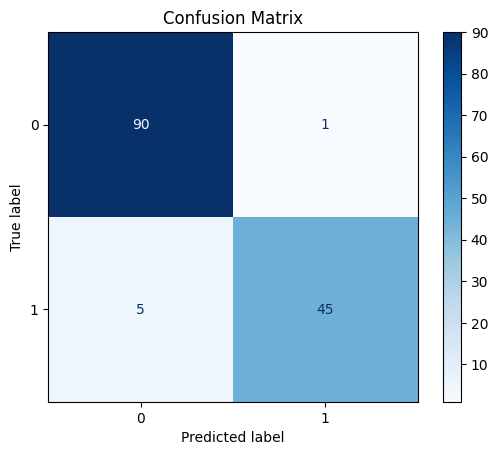

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras import Input
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, MinMaxScaler
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay

# Load and preprocess dataset
df = pd.read_csv('autism_screening.csv')
df = df.dropna()
columns_to_drop = ['used_app_before', 'country_of_res', 'age_desc', 'relation', 'who_completed_the_test']
df = df.drop(columns=[col for col in columns_to_drop if col in df.columns])

# Encode categorical variables
le = LabelEncoder()
for col in df.columns:
    if df[col].dtype == 'object':
        df[col] = le.fit_transform(df[col])

# Normalize
X = MinMaxScaler().fit_transform(df.drop('Class/ASD', axis=1))
y = df['Class/ASD'].values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

train_losses = []
train_accuracies = []

# Model architecture
def create_model():
    return Sequential([
        Input(shape=(X_train.shape[1],)),
        Dense(12, activation='relu'),
        Dense(1, activation='sigmoid')
    ])

# Flatten/unflatten weights
def flatten_weights(weights):
    return np.concatenate([w.flatten() for w in weights])

def unflatten_weights(flattened, model):
    shapes = [w.shape for w in model.get_weights()]
    new_weights, idx = [], 0
    for shape in shapes:
        size = np.prod(shape)
        new_weights.append(flattened[idx:idx+size].reshape(shape))
        idx += size
    return new_weights

# Fitness function = loss on train set
def fitness(position, return_metrics=False):
    model = create_model()
    model.set_weights(unflatten_weights(position, model))
    y_pred_probs = model.predict(X_train, verbose=0).flatten()
    loss = tf.keras.losses.binary_crossentropy(y_train, y_pred_probs).numpy().mean()
    y_pred_classes = (y_pred_probs > 0.5).astype(int)
    acc = accuracy_score(y_train, y_pred_classes)
    if return_metrics:
        return loss, acc
    return loss

# I-GWO Parameters
n_wolves = 50
n_iter = 100
a_decay = 2  # controls convergence

model_example = create_model()
dim = len(flatten_weights(model_example.get_weights()))
lb, ub = -1 * np.ones(dim), 1 * np.ones(dim)

# Initialize wolves
positions = np.random.uniform(lb, ub, (n_wolves, dim))
fitnesses = np.array([fitness(pos) for pos in positions])

# Identify alpha, beta, delta
sorted_indices = np.argsort(fitnesses)
alpha_pos, beta_pos, delta_pos = positions[sorted_indices[0]], positions[sorted_indices[1]], positions[sorted_indices[2]]

# Main I-GWO loop
for t in range(n_iter):
    a = a_decay - t * (a_decay / n_iter)
    print(f"\nIteration {t+1}/{n_iter}")

    for i in range(n_wolves):
        r1, r2 = np.random.rand(dim), np.random.rand(dim)
        A1 = 2 * a * r1 - a
        C1 = 2 * r2
        D_alpha = np.abs(C1 * alpha_pos - positions[i])
        X1 = alpha_pos - A1 * D_alpha

        r1, r2 = np.random.rand(dim), np.random.rand(dim)
        A2 = 2 * a * r1 - a
        C2 = 2 * r2
        D_beta = np.abs(C2 * beta_pos - positions[i])
        X2 = beta_pos - A2 * D_beta

        r1, r2 = np.random.rand(dim), np.random.rand(dim)
        A3 = 2 * a * r1 - a
        C3 = 2 * r2
        D_delta = np.abs(C3 * delta_pos - positions[i])
        X3 = delta_pos - A3 * D_delta

        # Improved position update
        new_position = (X1 + X2 + X3) / 3
        new_position = np.clip(new_position, lb, ub)
        positions[i] = new_position

    # Update fitness
    fitnesses = np.array([fitness(pos) for pos in positions])
    sorted_indices = np.argsort(fitnesses)
    alpha_pos, beta_pos, delta_pos = positions[sorted_indices[0]], positions[sorted_indices[1]], positions[sorted_indices[2]]
    g_best_position = alpha_pos.copy()

    current_loss, current_acc = fitness(g_best_position, return_metrics=True)
    train_losses.append(current_loss)
    train_accuracies.append(current_acc)
    print(f"Train Loss: {current_loss:.4f} | Train Accuracy: {current_acc:.4f}")

# Evaluate final model
final_model = create_model()
final_model.set_weights(unflatten_weights(g_best_position, final_model))

# Predict on test set
y_pred_probs = final_model.predict(X_test, verbose=0).flatten()
y_pred = (y_pred_probs > 0.5).astype(int)

# Compute final metrics
test_accuracy = accuracy_score(y_test, y_pred)
test_loss = tf.keras.losses.binary_crossentropy(y_test, y_pred_probs).numpy().mean()

# Print results
print(f"\nTest Accuracy: {test_accuracy:.4f}")
print(f"Test Loss: {test_loss:.4f}")
plt.figure(figsize=(10, 5))

# Plot Training Loss
plt.plot(range(1, n_iter + 1), train_losses, label='Training Loss', color='red')

# Plot Training Accuracy
plt.plot(range(1, n_iter + 1), train_accuracies, label='Training Accuracy', color='blue')

plt.title("Training Metrics Over Iterations (I-GWO)")
plt.xlabel("Iteration")
plt.ylabel("Value")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix")
plt.grid(False)
plt.show()
